In [1]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [13]:
base_dir = r'C:\Users\asus\Desktop\img\train'
batch_size = 32
img_size = 128
training_set = tf.keras.utils.image_dataset_from_directory(base_dir,label_mode="int",validation_split=0.02,subset="training",seed=100,image_size=(img_size, img_size),batch_size=batch_size)
validation_set = tf.keras.utils.image_dataset_from_directory( base_dir,validation_split=0.2,subset="validation",seed=100,image_size=(img_size, img_size),batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Using 3053 files for training.
Found 3115 files belonging to 36 classes.
Using 623 files for validation.


In [14]:
x_train = np.array([])
for x, y in training_set:
  x_train = np.concatenate([x])
  
x_test = np.array([])
for x, y in validation_set:
  x_test = np.concatenate([x])

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


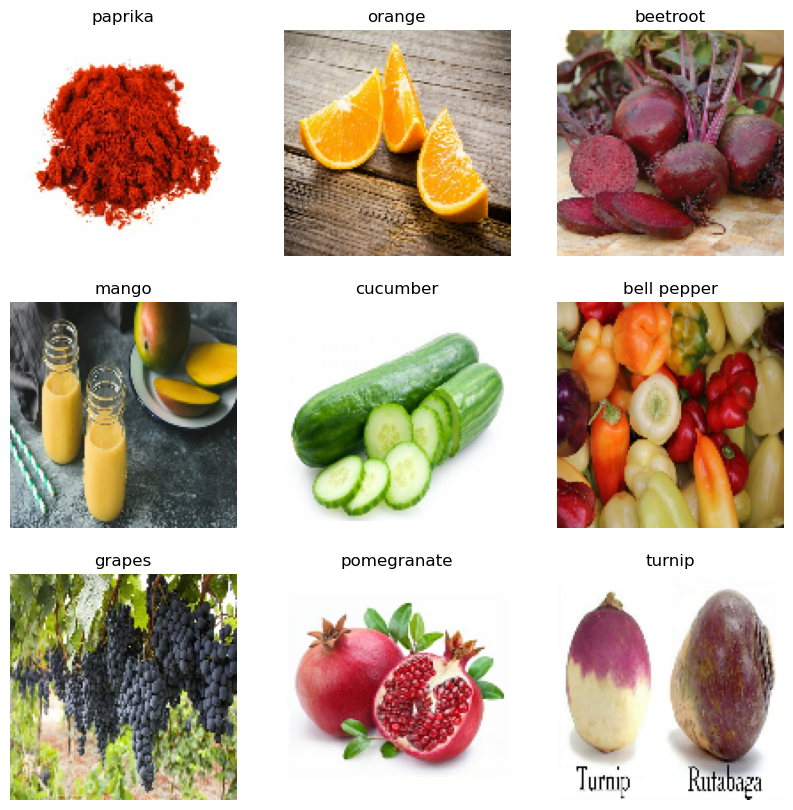

In [15]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [17]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [18]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

In [19]:
# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [21]:
num_features = shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3]

In [22]:
# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [26]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 2),               4531556   
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       3320483   
                                                                 
Total params: 7852039 (29.95 MB)
Trainable params: 7852039 (29.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [28]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

In [29]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=500, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 6276096.5000 - kl_loss: 0.0020 - reconstruction_loss: 6276.0967 - val_loss: 121753400.0000 - val_kl_loss: 115225928.0000 - val_reconstruction_loss: 6527.4854
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 141945072.0000 - kl_loss: 135304752.0000 - reconstruction_loss: 6640.3174 - val_loss: 5512807.0000 - val_kl_loss: 4.0487 - val_reconstruction_loss: 5512.8032
Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 6253483.0000 - kl_loss: 5.2474 - reconstruction_loss: 6253.4775 - val_loss: 5500063.5000 - val_kl_loss: 5.0145 - val_reconstruction_loss: 5500.0586
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 6235926.0000 - kl_loss: 5.9526 - reconstruction_loss: 6235.9209 - val_loss: 5486841.5000 - val_kl_loss: 3.2044 - val_reconstruction_loss: 5486.8379
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 6217823.5000 - kl_loss: 3.7167 - recon

1/1 [==============================] - 1s 728ms/step


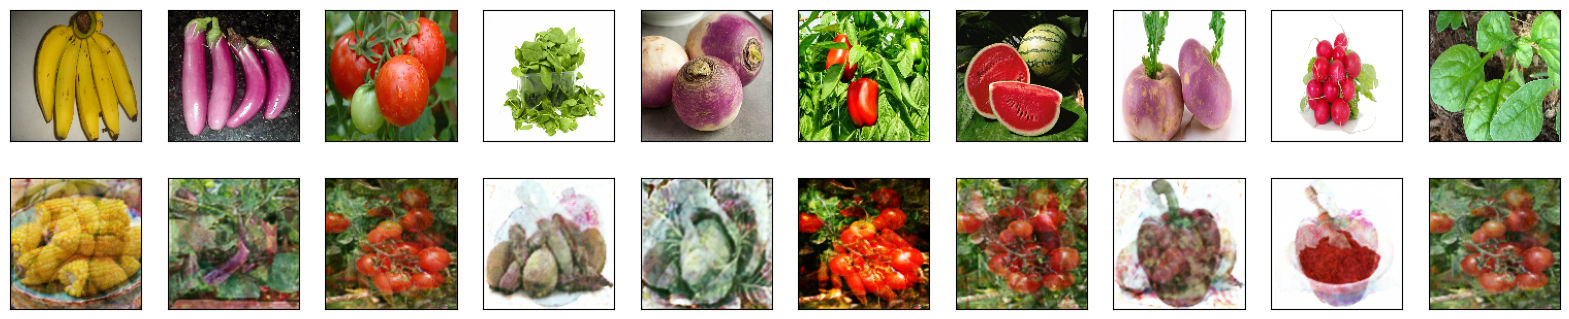

In [30]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 353ms/step


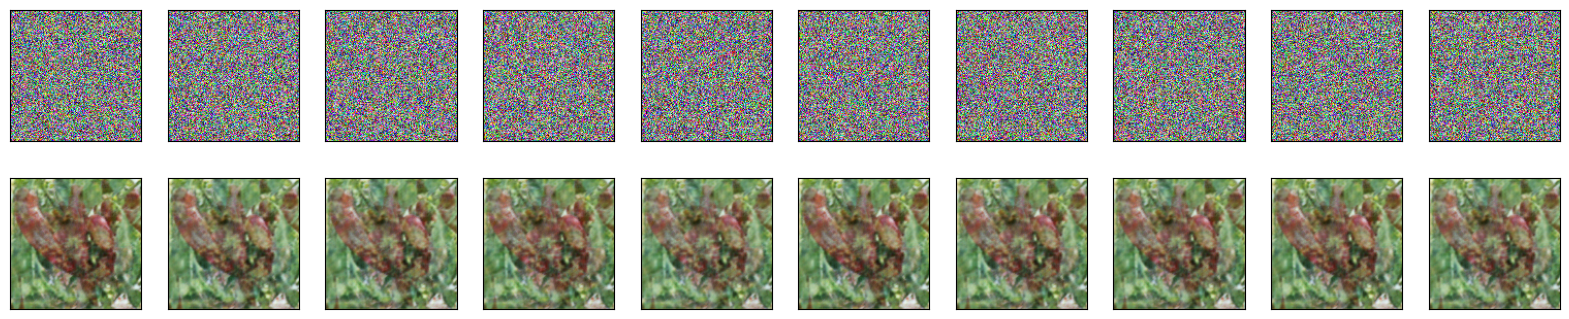

In [31]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()